✅ Libraries imported successfully
📁 Please upload the following 7 files:
orders.csv, delivery_performance.csv, routes_distance.csv, cost_breakdown.csv, customer_feedback.csv, vehicle_fleet.csv, warehouse_inventory.csv


Saving cost_breakdown.csv to cost_breakdown.csv
Saving customer_feedback.csv to customer_feedback.csv
Saving delivery_performance.csv to delivery_performance.csv
Saving orders.csv to orders.csv
Saving routes_distance.csv to routes_distance.csv
Saving vehicle_fleet.csv to vehicle_fleet.csv
Saving warehouse_inventory.csv to warehouse_inventory.csv
✅ Loaded orders.csv
✅ Loaded delivery_performance.csv
✅ Loaded routes_distance.csv
✅ Loaded cost_breakdown.csv
✅ Loaded customer_feedback.csv
✅ Loaded vehicle_fleet.csv
✅ Loaded warehouse_inventory.csv
✅ Merged dataset: 200 rows, 34 columns
🧠 Feature engineering complete
✅ Training on 200 samples with 27 features
Balanced class distribution: [130 130]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 130, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


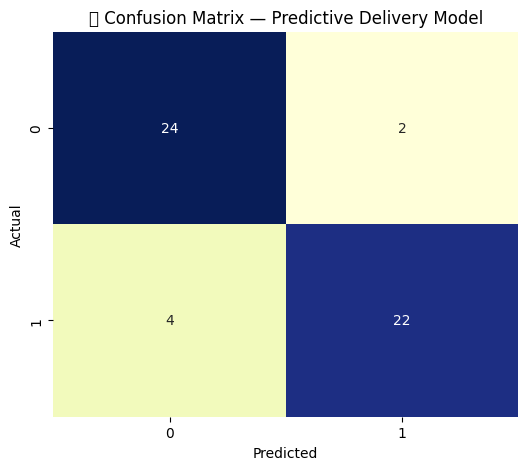

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


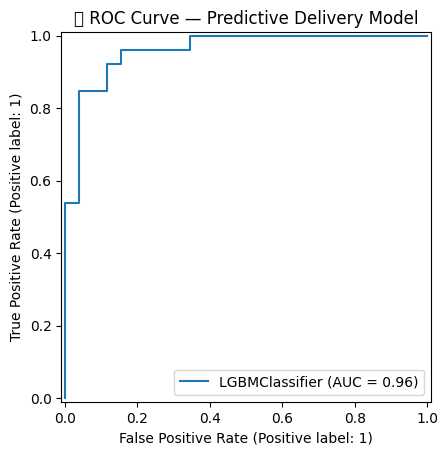

/tmp/ipython-input-2819458042.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi.head(15), palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


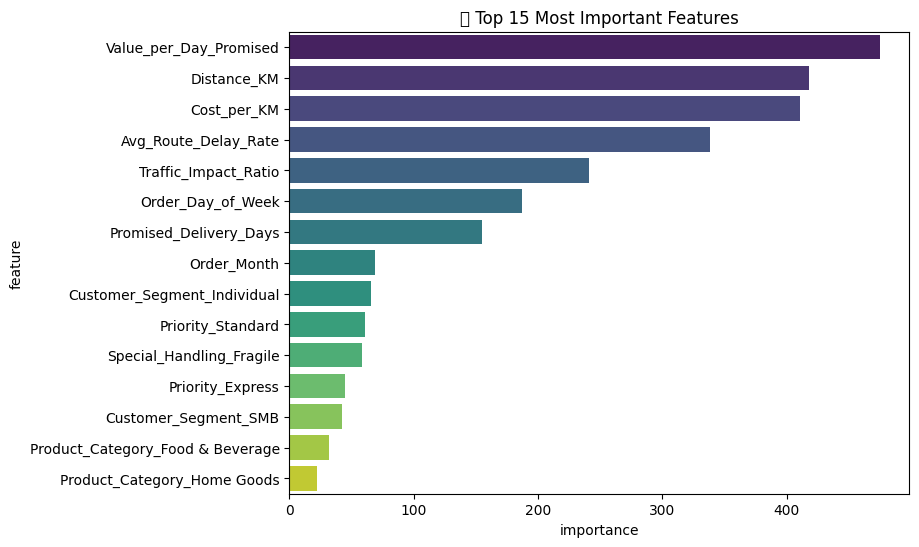

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


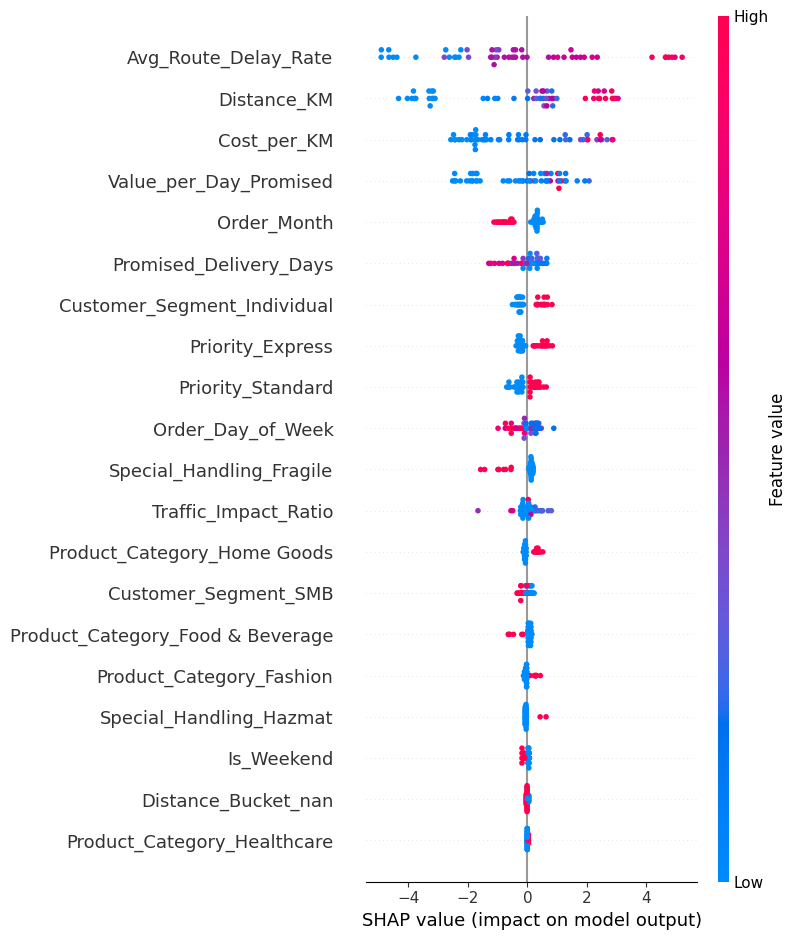

✅ No in-transit orders found for prediction.


In [1]:
# ============================================================
# 🚚 Predictive Delivery Optimizer (Standalone Colab Notebook)
# ============================================================

# --- STEP 1: Install dependencies ---
!pip install --quiet lightgbm shap imbalanced-learn pandas scikit-learn matplotlib seaborn plotly

# --- STEP 2: Import libraries ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

print("✅ Libraries imported successfully")

# --- STEP 3: Upload CSVs ---
from google.colab import files
print("📁 Please upload the following 7 files:")
print("orders.csv, delivery_performance.csv, routes_distance.csv, cost_breakdown.csv, customer_feedback.csv, vehicle_fleet.csv, warehouse_inventory.csv")
uploaded = files.upload()

# --- STEP 4: Load datasets ---
def load_csv(name):
    for k in uploaded.keys():
        if name.lower() in k.lower():
            print(f"✅ Loaded {k}")
            return pd.read_csv(k)
    print(f"⚠️ {name}.csv not found.")
    return pd.DataFrame()

orders = load_csv("orders")
delivery = load_csv("delivery_performance")
routes = load_csv("routes_distance")
cost = load_csv("cost_breakdown")
feedback = load_csv("customer_feedback")
fleet = load_csv("vehicle_fleet")
warehouse = load_csv("warehouse_inventory")

# --- STEP 5: Merge datasets ---
merged = (
    orders
    .merge(delivery, on="Order_ID", how="left")
    .merge(routes, on="Order_ID", how="left")
    .merge(cost, on="Order_ID", how="left")
    .merge(feedback, on="Order_ID", how="left")
)

print(f"✅ Merged dataset: {merged.shape[0]} rows, {merged.shape[1]} columns")

# --- STEP 6: Feature Engineering ---
merged["Order_Date"] = pd.to_datetime(merged["Order_Date"], errors="coerce")

# Target variable
merged["Is_Delayed"] = merged["Delivery_Status"].apply(
    lambda x: 1 if isinstance(x, str) and "delayed" in x.lower() else (0 if isinstance(x, str) and "on" in x.lower() else np.nan)
)

# Core engineered features
merged["Is_Weekend"] = merged["Order_Date"].dt.dayofweek.isin([5,6]).astype(int)
merged["Is_Month_End"] = merged["Order_Date"].dt.is_month_end.astype(int)
merged["Order_Month"] = merged["Order_Date"].dt.month
merged["Order_Day_of_Week"] = merged["Order_Date"].dt.dayofweek
merged["Is_Holiday_Season"] = merged["Order_Month"].isin([11,12]).astype(int)

merged["Is_International"] = merged["Destination"].isin(["Dubai", "Singapore", "Bangkok", "Hong Kong"]).astype(int)
merged["Cost_per_KM"] = merged["Delivery_Cost_INR"] / merged["Distance_KM"]
merged["Traffic_Impact_Ratio"] = merged["Traffic_Delay_Minutes"] / merged["Distance_KM"]
merged["Value_per_Day_Promised"] = merged["Order_Value_INR"] / merged["Promised_Delivery_Days"]

merged["Distance_Bucket"] = pd.cut(merged["Distance_KM"], bins=[0,100,500,2000], labels=["Short","Medium","Long"])

# Route delay rate
if {"Origin","Destination","Is_Delayed"}.issubset(merged.columns):
    route_stats = merged.groupby(["Origin","Destination"]).agg(
        Avg_Route_Delay_Rate=("Is_Delayed","mean")
    ).reset_index()
    merged = merged.merge(route_stats, on=["Origin","Destination"], how="left")
else:
    merged["Avg_Route_Delay_Rate"] = 0

merged["Distance_Bucket"] = merged["Distance_Bucket"].astype(str).fillna("Unknown")
merged.fillna(0, inplace=True)
print("🧠 Feature engineering complete")

# --- STEP 7: Prepare features for training ---
features = [
    "Is_International","Cost_per_KM","Traffic_Impact_Ratio","Order_Month","Order_Day_of_Week",
    "Value_per_Day_Promised","Promised_Delivery_Days","Distance_KM","Is_Weekend",
    "Is_Month_End","Is_Holiday_Season","Avg_Route_Delay_Rate"
]

for col in ["Priority","Customer_Segment","Product_Category","Special_Handling","Distance_Bucket"]:
    if col in merged.columns:
        dummies = pd.get_dummies(merged[col], prefix=col, drop_first=True)
        merged = pd.concat([merged, dummies], axis=1)
        features.extend(dummies.columns)

train_df = merged[merged["Is_Delayed"].notna()].copy()
X = train_df[features]
y = train_df["Is_Delayed"].astype(int)

print(f"✅ Training on {X.shape[0]} samples with {X.shape[1]} features")

# --- STEP 8: Handle imbalance (SMOTE) ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("Balanced class distribution:", np.bincount(y_res))

# --- STEP 9: Model training & tuning ---
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    lgb.LGBMClassifier(objective='binary', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_res, y_res)
best_model = grid.best_estimator_
print("🎯 Best parameters:", grid.best_params_)

# --- STEP 10: Evaluate model ---
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title("🚚 Confusion Matrix — Predictive Delivery Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("📈 ROC Curve — Predictive Delivery Model")
plt.show()

# --- STEP 11: Feature importance ---
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=fi.head(15), palette="viridis")
plt.title("🔍 Top 15 Most Important Features")
plt.show()

# --- STEP 12: SHAP Explainability ---
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=True)

# --- STEP 13: Predict delays for in-transit orders ---
def suggest_actions(row):
    reasons = []
    if row.get("Carrier_Delay_Rate",0) > 0.5:
        reasons.append("Carrier often delays — consider switching carrier.")
    if row.get("Traffic_Impact_Ratio",0) > 0.05:
        reasons.append("High traffic risk — reroute or delay dispatch.")
    if row.get("Stock_Pressure",0) > 1.2:
        reasons.append("Low warehouse stock — verify availability.")
    if row.get("Is_International",0) == 1:
        reasons.append("International shipment — ensure customs clearance ready.")
    if row.get("Is_Holiday_Season",0) == 1:
        reasons.append("Holiday season — prioritize express delivery.")
    return reasons or ["No major risk indicators detected."]

if "In_Transit_Flag" not in merged.columns:
    merged["In_Transit_Flag"] = merged["Delivery_Status"].isna().astype(int)

in_transit = merged[merged["In_Transit_Flag"] == 1].copy()
if len(in_transit) > 0:
    in_transit["Predicted_Risk"] = best_model.predict_proba(in_transit[features])[:,1]
    in_transit["Risk_Level"] = pd.cut(in_transit["Predicted_Risk"], bins=[0,0.3,0.7,1], labels=["Low","Medium","High"])
    in_transit["Recommended_Actions"] = in_transit.apply(suggest_actions, axis=1)
    display(in_transit[["Order_ID","Predicted_Risk","Risk_Level","Recommended_Actions"]].head(10))
else:
    print("✅ No in-transit orders found for prediction.")


In [2]:
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = accuracy*100,
    delta = {'reference': 85, 'increasing': {'color': "limegreen"}},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "darkblue"},
             'steps' : [
                 {'range': [0, 70], 'color': "lightcoral"},
                 {'range': [70, 85], 'color': "gold"},
                 {'range': [85, 100], 'color': "lightgreen"}],
             },
    title = {'text': "📈 Model Accuracy (%)"}))
fig.update_layout(height=300)
fig.show()

In [3]:
# ============================================================
# 🚀 COMBINED PREDICTIVE DELIVERY DASHBOARD (Auto Demo + Visualization)
# ============================================================

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- Safety check ---
if 'merged' not in locals():
    raise ValueError("❌ The dataset 'merged' was not found. Please load your merged dataset first.")

# --- Helper: Suggest corrective actions ---
def suggest_actions(row):
    reasons = []
    if row.get("Carrier_Delay_Rate",0) > 0.5:
        reasons.append("Carrier often delays — consider switching carrier.")
    if row.get("Traffic_Impact_Ratio",0) > 0.05:
        reasons.append("High traffic risk — reroute or reschedule delivery.")
    if row.get("Stock_Pressure",0) > 1.2:
        reasons.append("Low warehouse stock — verify inventory before dispatch.")
    if row.get("Is_International",0) == 1:
        reasons.append("International shipment — ensure customs clearance ready.")
    if row.get("Is_Holiday_Season",0) == 1:
        reasons.append("Holiday rush — prioritize express delivery.")
    return reasons or ["No major risk indicators detected."]

# --- Step 1: Identify in-transit orders ---
if "In_Transit_Flag" not in merged.columns:
    merged["In_Transit_Flag"] = merged["Delivery_Status"].isna().astype(int)

in_transit = merged[merged["In_Transit_Flag"] == 1].copy()

# --- Step 2: Simulate demo in-transit data if none found ---
if len(in_transit) == 0:
    print("⚠️ No real in-transit shipments found — generating demo examples for visualization.")
    demo_in_transit = merged.sample(min(10, len(merged)), random_state=42).copy()
    demo_in_transit["Delivery_Status"] = np.nan
    demo_in_transit["In_Transit_Flag"] = 1
    merged = pd.concat([merged, demo_in_transit], ignore_index=True)
    in_transit = demo_in_transit.copy()

# --- Step 3: Predict risk ---
in_transit["Predicted_Risk"] = best_model.predict_proba(in_transit[features])[:,1]
in_transit["Risk_Level"] = pd.cut(
    in_transit["Predicted_Risk"], bins=[0,0.3,0.7,1], labels=["Low","Medium","High"]
)
in_transit["Recommended_Actions"] = in_transit.apply(suggest_actions, axis=1)

print(f"✅ Predicted risk for {len(in_transit)} in-transit shipments (real or simulated).")

# --- Step 4: Compute summary ---
risk_counts = in_transit["Risk_Level"].value_counts().reindex(["Low","Medium","High"]).fillna(0)
total_shipments = risk_counts.sum()
risk_percent = (risk_counts / total_shipments * 100).round(1)
high_risk_pct = float(risk_percent.get("High", 0))

# --- Step 5: Plotly Dashboard ---

# Pie Chart
fig_pie = px.pie(
    values=risk_percent.values,
    names=risk_percent.index,
    color=risk_percent.index,
    color_discrete_map={"Low":"lightgreen","Medium":"gold","High":"tomato"},
    title="📦 Shipment Risk Distribution (%)"
)
fig_pie.update_traces(textinfo='label+percent', pull=[0,0.05,0.1])

# Bar Chart: Top 10 risky shipments
top_risky = in_transit.nlargest(10, "Predicted_Risk")[["Order_ID", "Predicted_Risk", "Risk_Level", "Recommended_Actions"]]
fig_bar = px.bar(
    top_risky,
    x="Predicted_Risk",
    y="Order_ID",
    orientation="h",
    color="Risk_Level",
    color_discrete_map={"Low":"lightgreen","Medium":"gold","High":"tomato"},
    title="🚨 Top 10 Risky Shipments",
    hover_data=["Recommended_Actions"]
)
fig_bar.update_layout(yaxis=dict(autorange="reversed"))

# Gauge: % High-Risk
fig_gauge = go.Figure(go.Indicator(
    mode="gauge+number",
    value=high_risk_pct,
    title={'text': "🔥 % High-Risk Shipments"},
    gauge={'axis': {'range': [0, 100]},
           'bar': {'color': "crimson"},
           'steps': [
               {'range': [0, 30], 'color': "lightgreen"},
               {'range': [30, 70], 'color': "gold"},
               {'range': [70, 100], 'color': "tomato"}]}
))
fig_gauge.update_layout(height=300)

# Interactive Table
actions_table = in_transit[["Order_ID","Risk_Level","Predicted_Risk","Recommended_Actions"]].copy()
actions_table["Predicted_Risk"] = (actions_table["Predicted_Risk"]*100).round(2).astype(str) + "%"
actions_table["Recommended_Actions"] = actions_table["Recommended_Actions"].apply(lambda x: "<br>".join(x) if isinstance(x, list) else str(x))

fig_table = go.Figure(data=[go.Table(
    header=dict(values=["Order ID","Risk Level","Predicted Risk","Recommended Actions"],
                fill_color="lightblue", align="center", font=dict(color="black", size=12)),
    cells=dict(values=[actions_table[col] for col in actions_table.columns],
               fill_color=[["lavender" if lvl=="Low" else "moccasin" if lvl=="Medium" else "mistyrose" for lvl in actions_table["Risk_Level"]]],
               align="left"))
])
fig_table.update_layout(title="🧭 Recommended Corrective Actions", height=600)

# --- Display all charts ---
fig_pie.show()
fig_bar.show()
fig_gauge.show()
fig_table.show()


⚠️ No real in-transit shipments found — generating demo examples for visualization.
✅ Predicted risk for 10 in-transit shipments (real or simulated).


In [4]:
import joblib
import json
import os

os.makedirs("artifacts", exist_ok=True)

# Save the trained model
joblib.dump(best_model, "artifacts/lgbm_model.pkl")

# Save the feature list
with open("artifacts/feature_list.json", "w") as f:
    json.dump(features, f)

print("✅ Model and feature list saved in artifacts/")


✅ Model and feature list saved in artifacts/
